Import libraries

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch, re
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score
)
import matplotlib
#matplotlib.use('TkAgg')  # or 'MacOSX' if on macOS
import matplotlib.pyplot as plt
print(matplotlib.__version__)
import numpy as np
from sklearn.model_selection import train_test_split


3.10.7


Read data

In [4]:
folder_path = "/Users/robinoscarsson/PycharmProjects/tra300-ski-technique-classification/data_sync/outputs"

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "NR" in f]

dataframes = {}
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes[file] = df


In [5]:

TEST_FILE = "BIA24-2_NR_merged_with_gear.csv"

input_cols = ["speed_kmph", "power_w", "frequency_ppm", "thrust_left_ms", "thrust_right_ms", "impulse_left_ns", "impulse_right_ns", "force_meanl_n", "force_meanr_n", "f_tot_mean_n"]
output_cols = ["Gear"]

print("Loaded CSV files:")
for k in sorted(dataframes.keys()):
    print(" •", k)

# Take a sample frame to list columns
_sample_key = next(iter(dataframes))
print("\nColumns in sample file:", _sample_key)
print(list(dataframes[_sample_key].columns))

print("\nUsing inputs:", input_cols)
print("Using output:", output_cols)

# Choose TEST file
if TEST_FILE is None:
    TEST_FILE = sorted(dataframes.keys())[0]
print("\nTest file:", TEST_FILE)


Loaded CSV files:
 • BIA24-15_NR_merged_with_gear.csv
 • BIA24-16_NR_merged_with_gear.csv
 • BIA24-18_NR_merged_with_gear.csv
 • BIA24-19_NR_merged_with_gear.csv
 • BIA24-20_NR_merged_with_gear.csv
 • BIA24-22_NR_merged_with_gear.csv
 • BIA24-2_NR_merged_with_gear.csv
 • BIA24-3_NR_merged_with_gear.csv
 • BIA24-4_NR_merged_with_gear.csv
 • BIA24-5_NR_merged_with_gear.csv
 • BIA24-7_NR_merged_with_gear.csv
 • BIA24-8_NR_merged_with_gear.csv
 • BIA24-9_NR_merged_with_gear.csv

Columns in sample file: BIA24-8_NR_merged_with_gear.csv
['sessionid', 'tt_s', 'distance_m', 'slope_pct', 'speed_kmph', 'power_w', 'heartrate_bpm', 'frequency_ppm', 'cycle', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'treadmill_force_n', 'altitude_m', 'latitude_deg', 'longitude_deg', 'usernote = None', 'Sport', 'ns1:Id', 'StartTime', 'ns1:TotalTimeSeconds', 'ns1:DistanceMeters', 'ns1:MaximumSpeed', 'ns1:Calories', 'ns1:Value', 'ns1:Va

In [18]:
# ---- Split into train/test files ----
train_keys = [k for k in dataframes.keys() if k != TEST_FILE]
test_key = TEST_FILE

train_df_full = pd.concat([dataframes[k] for k in train_keys], ignore_index=True) # Renamed
test_df = dataframes[test_key].copy()

needed_cols = list(set(input_cols + output_cols))
train_df_full = train_df_full.dropna(subset=needed_cols).reset_index(drop=True)
test_df = test_df.dropna(subset=needed_cols).reset_index(drop=True)

# ---- Normalize labels: "2.0H" / "2.0V" / "2.0" -> "2.0" ----
label_col = output_cols[0]

def normalize_label(val: object) -> str:
    s = str(val).strip()
    m = re.search(r'^-?\d+(?:\.\d+)?', s) # take leading number (int or float)
    if m:
        return f"{float(m.group(0)):.1f}" # standardize format, e.g., 2 -> "2.0"
    return s # fall back to original string

train_df_full[label_col] = train_df_full[label_col].apply(normalize_label)
test_df[label_col] = test_df[label_col].apply(normalize_label)

# ==== NEW: Create Train/Validation Split ====
# We split the full training data into a new (smaller) training set
# and a validation set.
try:
    train_df, val_df = train_test_split(
        train_df_full,
        test_size=0.2, # 20% for validation
        random_state=42,
        stratify=train_df_full[label_col] # Keep class distribution in splits
    )
except ValueError:
    print("Warning: Could not stratify split (likely due to rare classes). Splitting without stratification.")
    train_df, val_df = train_test_split(
        train_df_full,
        test_size=0.2, # 20% for validation
        random_state=42
    )

# ---- Encode labels using ALL labels (train_full + test) to avoid unseen-label errors ----
label_encoder = LabelEncoder()
all_labels = pd.concat(
    [train_df_full[label_col], test_df[label_col]], # Use train_df_full here
    ignore_index=True
)
label_encoder.fit(all_labels)

y_train = label_encoder.transform(train_df[label_col]) # Use new train_df
y_val = label_encoder.transform(val_df[label_col])     # Create y_val
y_test = label_encoder.transform(test_df[label_col])
num_classes = len(label_encoder.classes_)

# Warn if any class exists only in test
train_classes = set(np.unique(y_train))
val_classes = set(np.unique(y_val))
test_classes = set(np.unique(y_test))

only_in_test = sorted(list(test_classes - train_classes - val_classes))
if only_in_test:
    names_only_in_test = [label_encoder.classes_[i] for i in only_in_test]
    print("⚠️ These classes exist only in TEST (not seen in train/val):", names_only_in_test)

# ---- Prepare inputs ----
X_train = train_df[input_cols].values.astype(np.float32)
X_val = val_df[input_cols].values.astype(np.float32)     # Create X_val
X_test = test_df[input_cols].values.astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Fit ONLY on the new, smaller X_train
X_val = scaler.transform(X_val)         # Transform X_val
X_test = scaler.transform(X_test)     # Transform X_test

# ---- Convert to PyTorch tensors ----
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)   # Create X_val_t
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.long)     # Create y_val_t
y_test_t = torch.tensor(y_test, dtype=torch.long)

SEQ_LEN = 10    # length of each sequence in seconds (samples)
STRIDE = 5      # how much to slide the window forward

def make_sequences(X_t, y_t, seq_len=SEQ_LEN, stride=STRIDE):
    """
    Turn flat sensor data (N x features) into overlapping sequences for RNNs.
    """
    X_seq, y_seq = [], []
    for i in range(0, len(X_t) - seq_len + 1, stride):
        X_seq.append(X_t[i:i+seq_len])
        y_seq.append(y_t[i+seq_len-1])
    X_seq = torch.stack(X_seq)      # shape: (num_sequences, seq_len, num_features)
    y_seq = torch.stack(y_seq)      # shape: (num_sequences,)
    return X_seq, y_seq

# Apply to train, val, and test
X_train_seq, y_train_seq = make_sequences(X_train_t, y_train_t)
X_val_seq, y_val_seq     = make_sequences(X_val_t, y_val_t)
X_test_seq, y_test_seq   = make_sequences(X_test_t, y_test_t)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_val_seq shape:   {X_val_seq.shape}")
print(f"X_test_seq shape:  {X_test_seq.shape}")

input_dim = X_train_t.shape[1]
output_dim = num_classes

# ---- Class weights (based on new, smaller training set) ----
counts_np = np.bincount(y_train, minlength=num_classes)
class_counts = torch.tensor(counts_np, dtype=torch.float32)
with torch.no_grad():
    class_weights = torch.where(class_counts > 0, 1.0 / class_counts, torch.tensor(0.0))
    nz = class_weights > 0
    if nz.any():
        class_weights[nz] = class_weights[nz] * (nz.sum() / class_weights[nz].sum())

print(f"Train size: {len(X_train_t)} | Val size: {len(X_val_t)} | Test size: {len(X_test_t)}")
print(f"Input dim: {input_dim} | Classes: {num_classes}")
print("Label mapping (int -> original):")
for i, name in enumerate(label_encoder.classes_):
    print(f"  {i} -> {name}")
print("Training Class counts:", counts_np.tolist())

X_train_seq shape: torch.Size([2121, 10, 10])
X_val_seq shape:   torch.Size([529, 10, 10])
X_test_seq shape:  torch.Size([195, 10, 10])
Train size: 10611 | Val size: 2653 | Test size: 984
Input dim: 10 | Classes: 4
Label mapping (int -> original):
  0 -> 0.0
  1 -> 2.0
  2 -> 3.0
  3 -> 4.0
Training Class counts: [2041, 1595, 5630, 1345]


RNN architecture

Starting training...
Epoch 001 | Train loss: 1.3999 | Val loss: 1.4037 | Val Acc: 0.4972
Epoch 002 | Train loss: 1.3944 | Val loss: 1.4002 | Val Acc: 0.4972
Epoch 003 | Train loss: 1.3925 | Val loss: 1.3984 | Val Acc: 0.4972
Epoch 004 | Train loss: 1.3900 | Val loss: 1.3952 | Val Acc: 0.4972
Epoch 005 | Train loss: 1.3875 | Val loss: 1.3910 | Val Acc: 0.4953
Epoch 006 | Train loss: 1.3832 | Val loss: 1.3844 | Val Acc: 0.4915
Epoch 007 | Train loss: 1.3772 | Val loss: 1.3763 | Val Acc: 0.4348
Epoch 008 | Train loss: 1.3703 | Val loss: 1.3682 | Val Acc: 0.3989
Epoch 009 | Train loss: 1.3642 | Val loss: 1.3575 | Val Acc: 0.3800
Epoch 010 | Train loss: 1.3551 | Val loss: 1.3447 | Val Acc: 0.3667
Epoch 011 | Train loss: 1.3447 | Val loss: 1.3300 | Val Acc: 0.3422
Epoch 012 | Train loss: 1.3320 | Val loss: 1.3125 | Val Acc: 0.3289
Epoch 013 | Train loss: 1.3157 | Val loss: 1.2917 | Val Acc: 0.3157
Epoch 014 | Train loss: 1.2972 | Val loss: 1.2725 | Val Acc: 0.3157
Epoch 015 | Train loss: 1.2

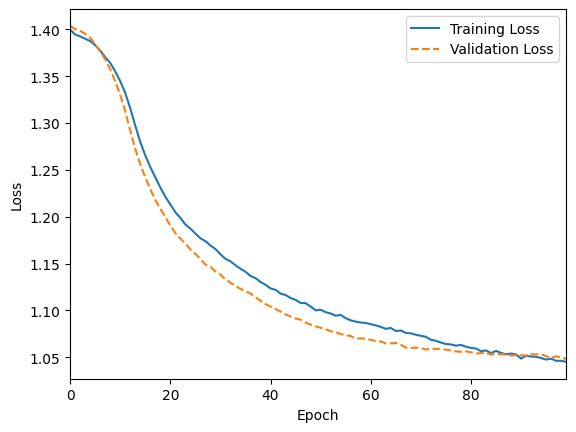

Training finished.

Using model state from final epoch for evaluation.


In [35]:
#Using the same workflow as for MLP
EPOCHS = 100
BATCH_SIZE = 256
PRINT_EVERY = 1

def batches(X, y, batch_size, shuffle=True):
    n = len(X)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for start in range(0, n, batch_size):
        end = start + batch_size
        sel = idx[start:end]
        yield X[sel], y[sel]

class_counts = torch.bincount(y_train_t)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts) / class_weights.sum())

model = nn.RNN(input_size=input_dim, hidden_size=8, num_layers=3, nonlinearity='relu', batch_first=True)
fc = nn.Linear(8, output_dim)  # Map hidden state → class logits
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")

def plot_training(epochs, train_losses, val_losses):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.xlabel("Epoch"), plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

for epoch in range(1, EPOCHS + 1):
    # --- Training Phase ---
    model.train()
    fc.train()
    running_loss = 0.0
    for Xb, yb in batches(X_train_seq, y_train_seq, BATCH_SIZE):
        optimizer.zero_grad()

        out, h_n = model(Xb)
        out = out[:, -1,:]
        out = fc(out)

        loss = criterion(out, yb)
        loss.backward()

        optimizer.step()
        running_loss += loss.item() * Xb.size(0)

    avg_train_loss = running_loss / len(X_train_seq)
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    fc.eval()

    val_loss = 0.0
    val_correct = 0
    total_samples = 0

    with torch.no_grad():
        for Xb, yb in batches(X_val_seq, y_val_seq, BATCH_SIZE, shuffle=False):
            out, _ = model(Xb)
            out = out[:, -1, :]
            out = fc(out)

            loss = criterion(out, yb)
            val_loss += loss.item() * Xb.size(0)   # weight by batch size

            preds = out.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            total_samples += Xb.size(0)

    avg_val_loss = val_loss / total_samples
    val_accuracy = val_correct / total_samples
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # --- Print Epoch Stats ---
    if epoch % PRINT_EVERY == 0:
        print(f"Epoch {epoch:03d} | Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

plot_training(EPOCHS, history['train_loss'], history['val_loss'])

    # --- (Removed "Save Best Model" block) ---

print("Training finished.")

# --- (Removed "Load Best Model" block) ---
print("\nUsing model state from final epoch for evaluation.")

[tensor([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 0, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,
        2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1,
        2, 1, 0])]
Test Accuracy: 0.5282


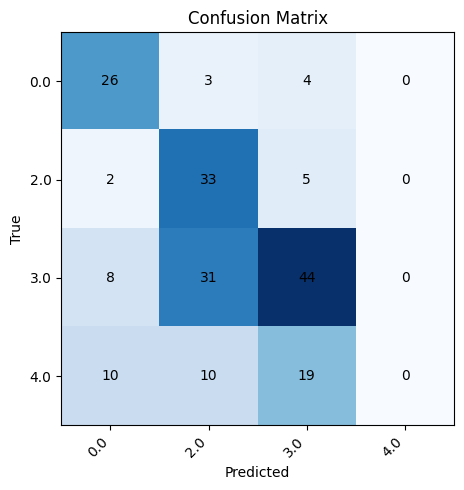

In [36]:
model.eval()
fc.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for Xb, yb in batches(X_test_seq, y_test_seq, BATCH_SIZE, shuffle=False):
        out, _ = model(Xb)          # (batch, seq_len, hidden)
        out = out[:, -1, :]       # take last timestep
        logits = fc(out)          # (batch, num_classes)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())

print(all_preds)
# Concatenate all batches
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_true).numpy()

# Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Confusion matrix
target_names = list(label_encoder.classes_)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(target_names)), labels=target_names)

# Annotate each cell
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()